In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    make_scorer,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KernelDensity, KNeighborsClassifier

## Load Iris Dataset

In [19]:
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris["data"], columns=iris["feature_names"])
df["y"] = iris["target"]
df["y"] = df["y"].map(dict(enumerate(iris.target_names)))

# Keep only rows where y is `Virginica` or `Versicolor`
df = df[df["y"].isin(["virginica", "versicolor"])]

# Keep only `sepal length (cm)` and `sepal width (cm)` columns

columns_to_keep = ["sepal length (cm)", "sepal width (cm)"]
df = df.loc[:, columns_to_keep + ["y"]]

In [20]:
print(f"Number of instances: {len(df)}")

Number of instances: 100


## Split Train/Test

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("y", axis=1), df["y"], test_size=0.3, random_state=51, stratify=df["y"]
)

## Preprocessing (Scaling)

Este paso realmente no es estrictamente necesario dado que las features que componen el conjunto de datos están en la misma escala (cm)

In [22]:
# Define the columns to be transformed
continuous_columns = X_train.select_dtypes(include=["float64"]).columns

# Crear el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_columns),
    ]
)

# Aplicar las transformaciones
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# X_train_virginica = X_train[y_train == "virginica"]
# X_train_versicolor = X_train[y_train == "versicolor"]

X_train = pd.DataFrame(X_train, columns=continuous_columns)
y_train = y_train.reset_index(drop=True)  # This is needed. Index is reset in X_train df

X_test = pd.DataFrame(X_test, columns=continuous_columns)
y_test = y_test.reset_index(drop=True)  # This is needed. Index is reset in X_test df

---

## KDE Classifier Wrapper

In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, bandwidth=0.1, kernel="gaussian"):
        self.bandwidth = bandwidth
        self.kernel = kernel

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.kdes_ = {}
        for c in self.classes_:
            X_cls = X[y == c]
            kde = KernelDensity(kernel=self.kernel, bandwidth=self.bandwidth)
            kde.fit(X_cls)
            self.kdes_[c] = kde
        return self

    def _log_prob(self, X):
        # For each class, compute the log probability density function
        logs = [self.kdes_[c].score_samples(X) for c in self.classes_]
        return np.vstack(logs).T  # shape (n_samples, n_classes)

    def predict(self, X):
        log_probs = self._log_prob(X)
        # Get the class with the highest log probability
        return self.classes_[np.argmax(log_probs, axis=1)]

    def predict_proba(self, X):
        log_probs = self._log_prob(X)
        probs = np.exp(log_probs)
        return probs / probs.sum(
            axis=1, keepdims=True
        )  # Normalize to get probabilities

## Hyperparameters Grid

In [10]:
params_grid = {
    "knn": {
        "model": KNeighborsClassifier,
        "params": {
            "n_neighbors": [1, 3, 5, 7, 9],
        },
    },
    "lda": {
        "model": LinearDiscriminantAnalysis,
        "params": {
            "solver": ["lsqr"],  # Using lsqr solver which supports shrinkage
            "shrinkage": np.arange(0, 1.01, 0.01),
        },
    },
    "kde": {
        "model": KDEClassifier,
        "params": {
            "bandwidth": np.arange(0.01, 1.01, 0.01),
            "kernel": ["gaussian", "tophat"],
        },
    },
}

## Optimization method grid

In [11]:
from sklearn.model_selection import (
    LeaveOneOut,
    ParameterGrid,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_val_predict,
    cross_validate,
)

cv_methods = {
    # To avoid only one class present, we use stratified method for K-Fold
    "10-fold": StratifiedKFold(n_splits=10, shuffle=True, random_state=51),
    "LOOCV": LeaveOneOut(),
    "5x2-stratified": RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=51),
}

bootstrap_reps = [10, 50, 100, 500, 1000]

In [12]:
# Define 'virginica' as the positive label
pos_label = "virginica"
scoring = {
    "accuracy": "accuracy",
    "f1": make_scorer(f1_score, pos_label=pos_label),
    "roc_auc": "roc_auc",
}

In [ ]:
import warnings

from sklearn.base import BaseEstimator
from sklearn.model_selection import BaseCrossValidator
from sklearn.utils import resample


def evaluate_model_with_cv(
    cv_name: str,
    cv_obj: BaseCrossValidator,
    model_name: str,
    params: dict,
    model: BaseEstimator,
) -> dict:
    try:
        if cv_name == "LOOCV":
            y_pred = cross_val_predict(
                model,
                X_train,
                y_train,
                cv=cv_obj,
                method="predict",
            )

            # Use try-except to handle potential issues with predict_proba
            try:
                y_pred_proba = cross_val_predict(
                    model,
                    X_train,
                    y_train,
                    cv=cv_obj,
                    method="predict_proba",
                )

                # Find the index for the positive class (virginica)
                classes = np.unique(y_train)
                pos_idx = np.where(classes == pos_label)[0][0]

                # Calculate ROC AUC with error handling
                try:
                    roc_auc = roc_auc_score(
                        y_train, y_pred_proba[:, pos_idx], labels=classes
                    )
                except (ValueError, IndexError):
                    # If ROC AUC calculation fails, use NaN
                    roc_auc = np.nan

            except (AttributeError, ValueError):
                # If predict_proba fails, use NaN for ROC AUC
                roc_auc = np.nan

            row = {
                "model": model_name,
                "cv": cv_name,
                **params,
                "accuracy": accuracy_score(y_train, y_pred),
                "f1": f1_score(y_train, y_pred, pos_label=pos_label),
                "roc_auc": roc_auc,
            }
        else:
            # For other CV methods
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                try:
                    cv_res = cross_validate(
                        model,
                        X_train,
                        y_train,
                        cv=cv_obj,
                        scoring=scoring,
                        return_train_score=False,
                        error_score=np.nan,  # Return NaN for errors instead of raising
                    )

                    row = {
                        "model": model_name,
                        "cv": cv_name,
                        **params,
                        "accuracy": cv_res["test_accuracy"].mean(),
                        "f1": cv_res["test_f1"].mean(),
                        "roc_auc": cv_res["test_roc_auc"].mean()
                        if "test_roc_auc" in cv_res
                        else np.nan,
                    }
                except Exception as e:
                    # Fallback for any other exceptions
                    print(f"Error during {cv_name} for {model_name}: {e}")
                    row = {
                        "model": model_name,
                        "cv": cv_name,
                        **params,
                        "accuracy": np.nan,
                        "f1": np.nan,
                        "roc_auc": np.nan,
                    }
    except Exception as e:
        print(f"Unexpected error for {model_name} with {cv_name}: {e}")
        row = {
            "model": model_name,
            "cv": cv_name,
            **params,
            "accuracy": np.nan,
            "f1": np.nan,
            "roc_auc": np.nan,
        }

    return row


def evaluate_model_with_bootstrap(
    n_bs: int, model_name: str, params: dict, model: BaseEstimator
) -> None:
    metrics = {m: [] for m in scoring.keys()}

    for _ in range(n_bs):
        X_bs, y_bs = resample(X_train, y_train, replace=True)

        try:
            model.fit(X_bs, y_bs)
            y_pred = model.predict(X_bs)

            # Calculate accuracy and f1
            metrics["accuracy"].append(accuracy_score(y_bs, y_pred))
            metrics["f1"].append(f1_score(y_bs, y_pred, pos_label=pos_label))

            # Try to get probabilities
            try:
                y_proba = model.predict_proba(X_bs)
                classes = model.classes_
                pos_idx = np.where(classes == pos_label)[0][0]
                metrics["roc_auc"].append(
                    roc_auc_score(y_bs, y_proba[:, pos_idx], labels=classes)
                )
            except (AttributeError, ValueError, IndexError):
                # If probabilities can't be obtained, use NaN for this bootstrap iteration
                metrics["roc_auc"].append(np.nan)
        except Exception:
            # If any fitting/prediction fails, use NaN for this iteration
            metrics["accuracy"].append(np.nan)
            metrics["f1"].append(np.nan)
            metrics["roc_auc"].append(np.nan)

    # Calculate means, ignoring NaN values
    row = {
        "model": model_name,
        "cv": "bootstrap",
        **params,
        "n_bootstrap": n_bs,
        "accuracy": np.nanmean(metrics["accuracy"]),
        "f1": np.nanmean(metrics["f1"]),
        "roc_auc": np.nanmean(metrics["roc_auc"]),
    }

    return row

In [14]:
results = []

for model_name, config in tqdm(params_grid.items()):
    model_class = config["model"]
    param_grid = config["params"]
    param_combinations = ParameterGrid(param_grid)

    for params in tqdm(param_combinations):
        # Create the model with the current parameters
        model = model_class(**params)

        for cv_name, cv_obj in cv_methods.items():
            # Use CV to evaluate models
            row = evaluate_model_with_cv(
                cv_name=cv_name,
                cv_obj=cv_obj,
                model_name=model_name,
                params=params,
                model=model,
            )
            results.append(row)

        # Bootstrap evaluation
        for n_bs in bootstrap_reps:
            row = evaluate_model_with_bootstrap(
                n_bs=n_bs,
                model_name=model_name,
                params=params,
                model=model,
            )
            results.append(row)

 67%|██████▋   | 2/3 [07:15<04:10, 250.32s/it]/var/folders/3f/6ggjjlbd55q4ryknfknwvqn80000gn/T/ipykernel_1536/3332822286.py:32: RuntimeWarning: invalid value encountered in divide
  return probs / probs.sum(
/var/folders/3f/6ggjjlbd55q4ryknfknwvqn80000gn/T/ipykernel_1536/3332822286.py:32: RuntimeWarning: invalid value encountered in divide
  return probs / probs.sum(
/var/folders/3f/6ggjjlbd55q4ryknfknwvqn80000gn/T/ipykernel_1536/3332822286.py:32: RuntimeWarning: invalid value encountered in divide
  return probs / probs.sum(
/var/folders/3f/6ggjjlbd55q4ryknfknwvqn80000gn/T/ipykernel_1536/3332822286.py:32: RuntimeWarning: invalid value encountered in divide
  return probs / probs.sum(
/var/folders/3f/6ggjjlbd55q4ryknfknwvqn80000gn/T/ipykernel_1536/3332822286.py:32: RuntimeWarning: invalid value encountered in divide
  return probs / probs.sum(
/var/folders/3f/6ggjjlbd55q4ryknfknwvqn80000gn/T/ipykernel_1536/3332822286.py:32: RuntimeWarning: invalid value encountered in divide
  return p

In [111]:
results_df = pd.DataFrame(results)

In [ ]:
results_df

,model,cv,n_neighbors,accuracy,f1,roc_auc,n_bootstrap,shrinkage,solver,bandwidth,kernel
0,knn,10-fold,1.0,0.514286,0.472727,0.520833,NaN,NaN,NaN,NaN,NaN
1,knn,LOOCV,1.0,0.500000,0.520548,0.500000,NaN,NaN,NaN,NaN,NaN
2,knn,5x2-stratified,1.0,0.492857,0.476701,0.492857,NaN,NaN,NaN,NaN,NaN
3,knn,bootstrap_10,1.0,0.951429,0.950534,0.951478,10.0,NaN,NaN,NaN,NaN
4,knn,bootstrap_50,1.0,0.951429,0.950540,0.949326,50.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2443,kde,bootstrap_10,NaN,0.728571,0.732030,0.811245,10.0,NaN,NaN,1.0,tophat
2444,kde,bootstrap_50,NaN,0.706286,0.708859,0.756181,50.0,NaN,NaN,1.0,tophat
2445,kde,bootstrap_100,NaN,0.692429,0.687799,0.757978,100.0,NaN,NaN,1.0,tophat
2446,kde,bootstrap_500,NaN,0.709514,0.712469,0.776196,500.0,NaN,NaN,1.0,tophat


In [5]:
# Transform the cv column for bootstrap
# to include the number of bootstrap samples
# This is done to make it easier to identify the number of bootstrap samples used
mask = results_df["cv"] == "bootstrap"
results_df.loc[mask, "cv"] = results_df[mask].apply(
    lambda x: f"bootstrap_{int(x['n_bootstrap'])}", axis=1
)

In [6]:
results_df

,model,cv,n_neighbors,accuracy,f1,roc_auc,n_bootstrap,shrinkage,solver,bandwidth,kernel
0,knn,10-fold,1.0,0.514286,0.472727,0.520833,NaN,NaN,NaN,NaN,NaN
1,knn,LOOCV,1.0,0.500000,0.520548,0.500000,NaN,NaN,NaN,NaN,NaN
2,knn,5x2-stratified,1.0,0.492857,0.476701,0.492857,NaN,NaN,NaN,NaN,NaN
3,knn,bootstrap_10,1.0,0.951429,0.950534,0.951478,10.0,NaN,NaN,NaN,NaN
4,knn,bootstrap_50,1.0,0.951429,0.950540,0.949326,50.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2443,kde,bootstrap_10,NaN,0.728571,0.732030,0.811245,10.0,NaN,NaN,1.0,tophat
2444,kde,bootstrap_50,NaN,0.706286,0.708859,0.756181,50.0,NaN,NaN,1.0,tophat
2445,kde,bootstrap_100,NaN,0.692429,0.687799,0.757978,100.0,NaN,NaN,1.0,tophat
2446,kde,bootstrap_500,NaN,0.709514,0.712469,0.776196,500.0,NaN,NaN,1.0,tophat


## Bootstrap Distribution

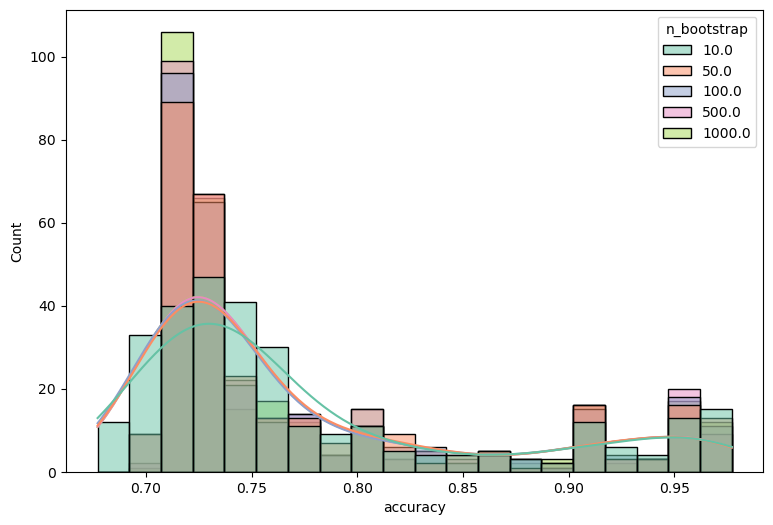

In [7]:
plt.figure(figsize=(9, 6))
sns.histplot(data=results_df, x="accuracy", hue="n_bootstrap", palette="Set2", kde=True)

plt.show()

## Plotting Metrics

### K-NN

In [8]:
knn_df = results_df[results_df["model"] == "knn"][
    ["cv", "n_neighbors", "accuracy", "f1", "roc_auc"]
]

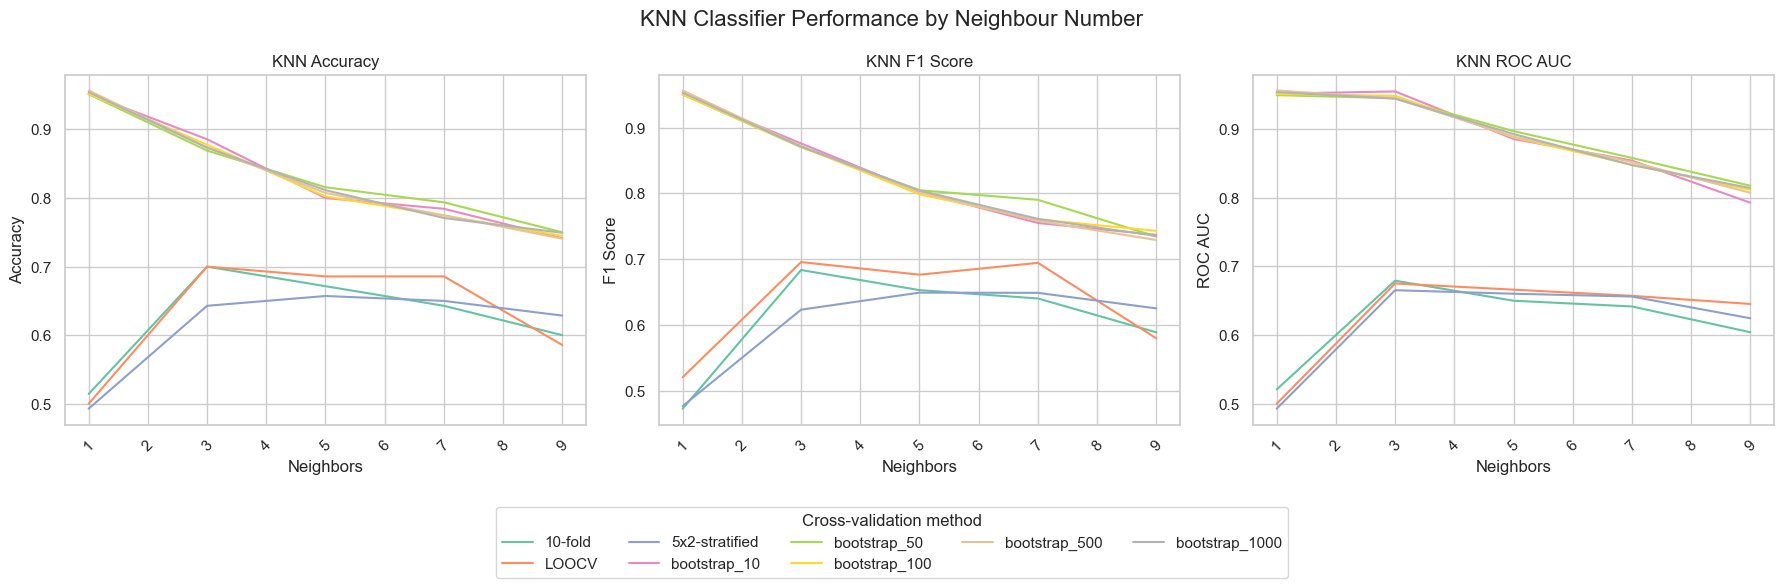

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Plot accuracy in the first subplot
sns.lineplot(
    data=knn_df,
    x="n_neighbors",
    y="accuracy",
    hue="cv",
    palette="Set2",
    markers=True,
    dashes=False,
    ax=axes[0],
)
axes[0].set_xlabel("Neighbors")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("KNN Accuracy")
axes[0].tick_params(axis="x", rotation=45)

# Plot F1 score in the second subplot
sns.lineplot(
    data=knn_df,
    x="n_neighbors",
    y="f1",
    hue="cv",
    palette="Set2",
    markers=True,
    dashes=False,
    ax=axes[1],
)
axes[1].set_xlabel("Neighbors")
axes[1].set_ylabel("F1 Score")
axes[1].set_title("KNN F1 Score")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend().set_visible(False)  # Hide redundant legend

# Plot ROC AUC in the third subplot
sns.lineplot(
    data=knn_df,
    x="n_neighbors",
    y="roc_auc",
    hue="cv",
    palette="Set2",
    markers=True,
    dashes=False,
    ax=axes[2],
)
axes[2].set_xlabel("Neighbors")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("KNN ROC AUC")
axes[2].tick_params(axis="x", rotation=45)
axes[2].legend().set_visible(False)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Cross-validation method",
    loc="upper center",
    bbox_to_anchor=(0.5, 0),
    ncol=5,
)
axes[0].get_legend().remove()  # Remove the individual legend from the first plot

fig.suptitle("KNN Classifier Performance by Neighbour Number", fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15)

plt.show()

### RDA

Debido a que en sklearn, se usa LDA con el parámetro `shrinkage`, el dataframe con las métricas contiene como nombre de modelo "lda". Lo más apropiado habría sido llamarle "rda". Este comentario pretende aclarar esta confusión.

In [10]:
lda_df = results_df[results_df["model"] == "lda"][
    ["cv", "shrinkage", "accuracy", "f1", "roc_auc"]
]


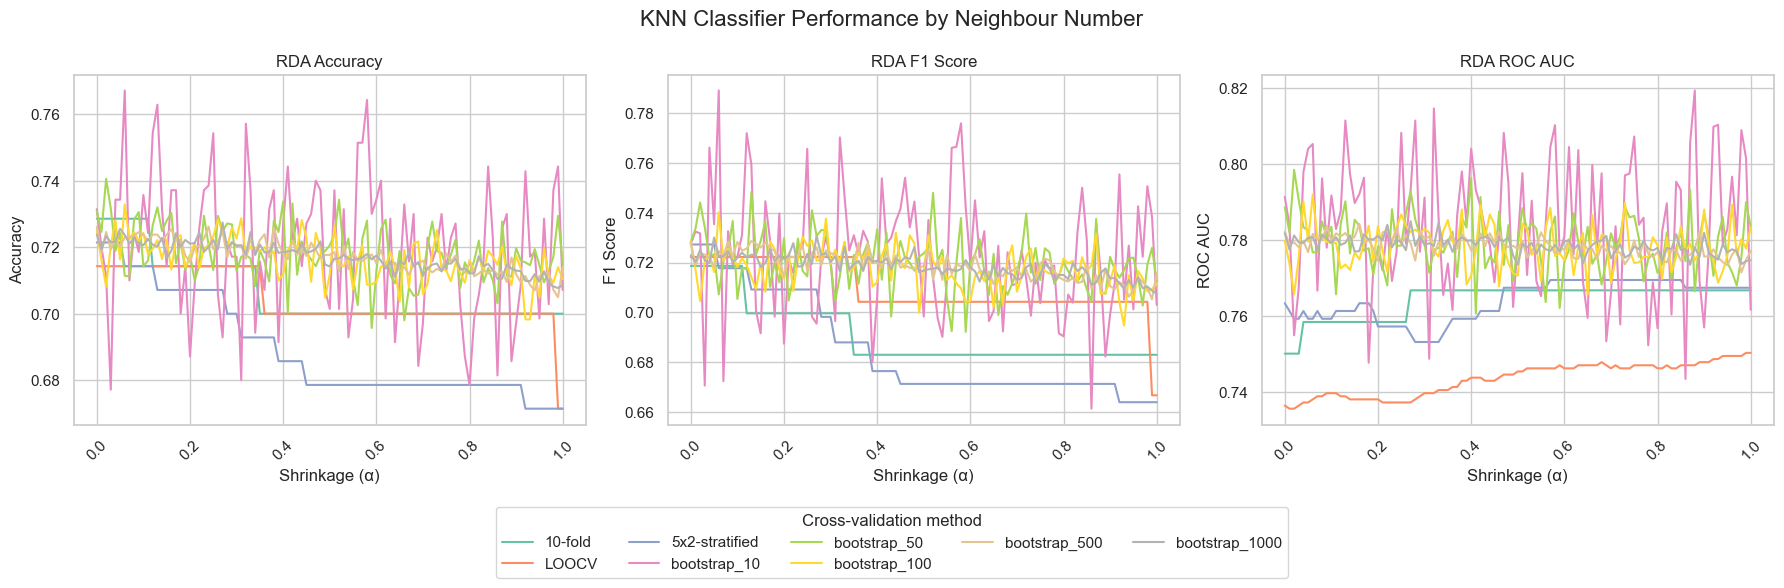

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Plot accuracy in the first subplot
sns.lineplot(
    data=lda_df,
    x="shrinkage",
    y="accuracy",
    hue="cv",
    palette="Set2",
    markers=True,
    dashes=False,
    ax=axes[0],
)
axes[0].set_xlabel("Shrinkage (α)")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("RDA Accuracy")
axes[0].tick_params(axis="x", rotation=45)

# Plot F1 score in the second subplot
sns.lineplot(
    data=lda_df,
    x="shrinkage",
    y="f1",
    hue="cv",
    palette="Set2",
    markers=True,
    dashes=False,
    ax=axes[1],
)
axes[1].set_xlabel("Shrinkage (α)")
axes[1].set_ylabel("F1 Score")
axes[1].set_title("RDA F1 Score")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend().set_visible(False)  # Hide redundant legend

# Plot ROC AUC in the third subplot
sns.lineplot(
    data=lda_df,
    x="shrinkage",
    y="roc_auc",
    hue="cv",
    palette="Set2",
    markers=True,
    dashes=False,
    ax=axes[2],
)
axes[2].set_xlabel("Shrinkage (α)")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("RDA ROC AUC")
axes[2].tick_params(axis="x", rotation=45)
axes[2].legend().set_visible(False)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Cross-validation method",
    loc="upper center",
    bbox_to_anchor=(0.5, 0),
    ncol=5,
)
axes[0].get_legend().remove()  # Remove the individual legend from the first plot

fig.suptitle("KNN Classifier Performance by Neighbour Number", fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15)

plt.show()

### KDE

In [12]:
kde_df = results_df[results_df["model"] == "kde"][
    ["cv", "bandwidth", "kernel", "accuracy", "f1", "roc_auc"]
]


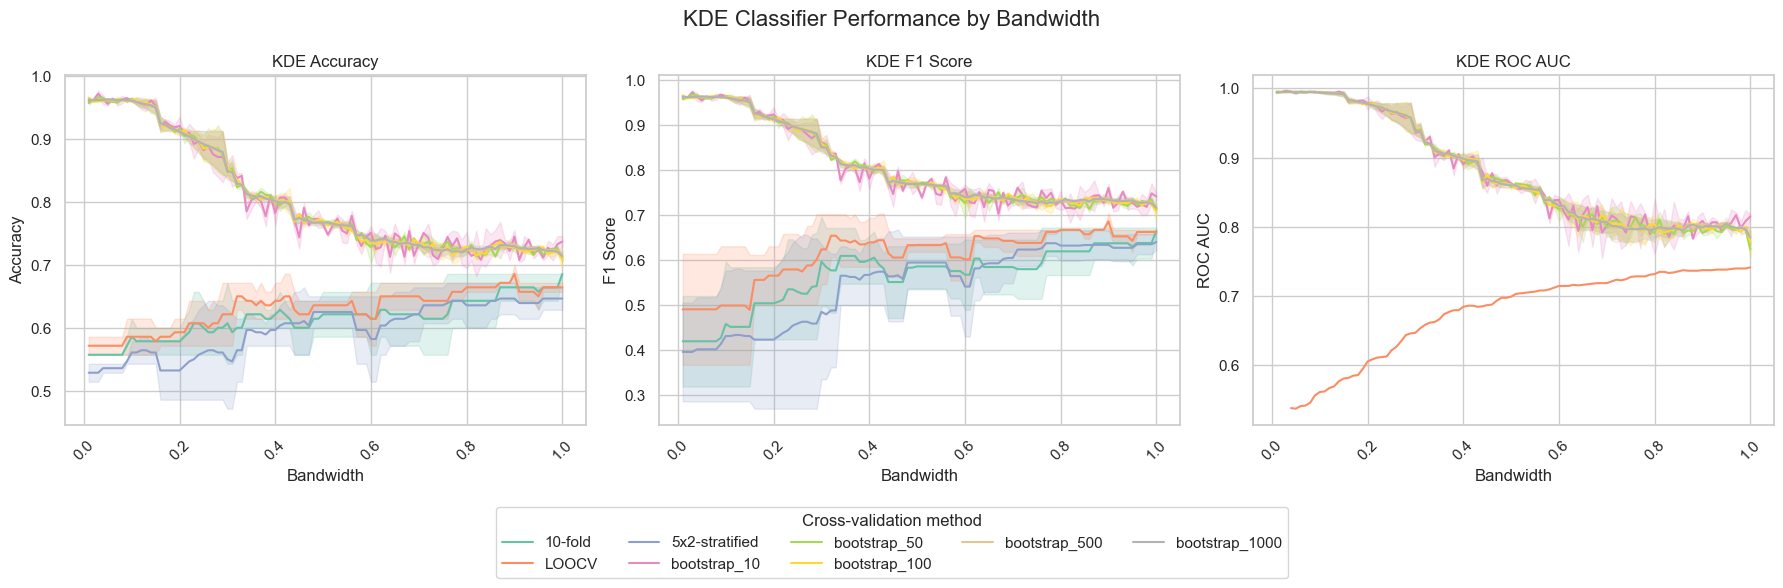

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Plot accuracy in the first subplot
sns.lineplot(
    data=kde_df,
    x="bandwidth",
    y="accuracy",
    hue="cv",
    palette="Set2",
    markers=True,
    dashes=False,
    ax=axes[0],
)
axes[0].set_xlabel("Bandwidth")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("KDE Accuracy")
axes[0].tick_params(axis="x", rotation=45)

# Plot F1 score in the second subplot
sns.lineplot(
    data=kde_df,
    x="bandwidth",
    y="f1",
    hue="cv",
    palette="Set2",
    markers=True,
    dashes=False,
    ax=axes[1],
)
axes[1].set_xlabel("Bandwidth")
axes[1].set_ylabel("F1 Score")
axes[1].set_title("KDE F1 Score")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend().set_visible(False)  # Hide redundant legend

# Plot ROC AUC in the third subplot
sns.lineplot(
    data=kde_df,
    x="bandwidth",
    y="roc_auc",
    hue="cv",
    palette="Set2",
    markers=True,
    dashes=False,
    ax=axes[2],
)
axes[2].set_xlabel("Bandwidth")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("KDE ROC AUC")
axes[2].tick_params(axis="x", rotation=45)
axes[2].legend().set_visible(False)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Cross-validation method",
    loc="upper center",
    bbox_to_anchor=(0.5, 0),
    ncol=5,
)
axes[0].get_legend().remove()  # Remove the individual legend from the first plot

fig.suptitle("KDE Classifier Performance by Bandwidth", fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15)

plt.show()

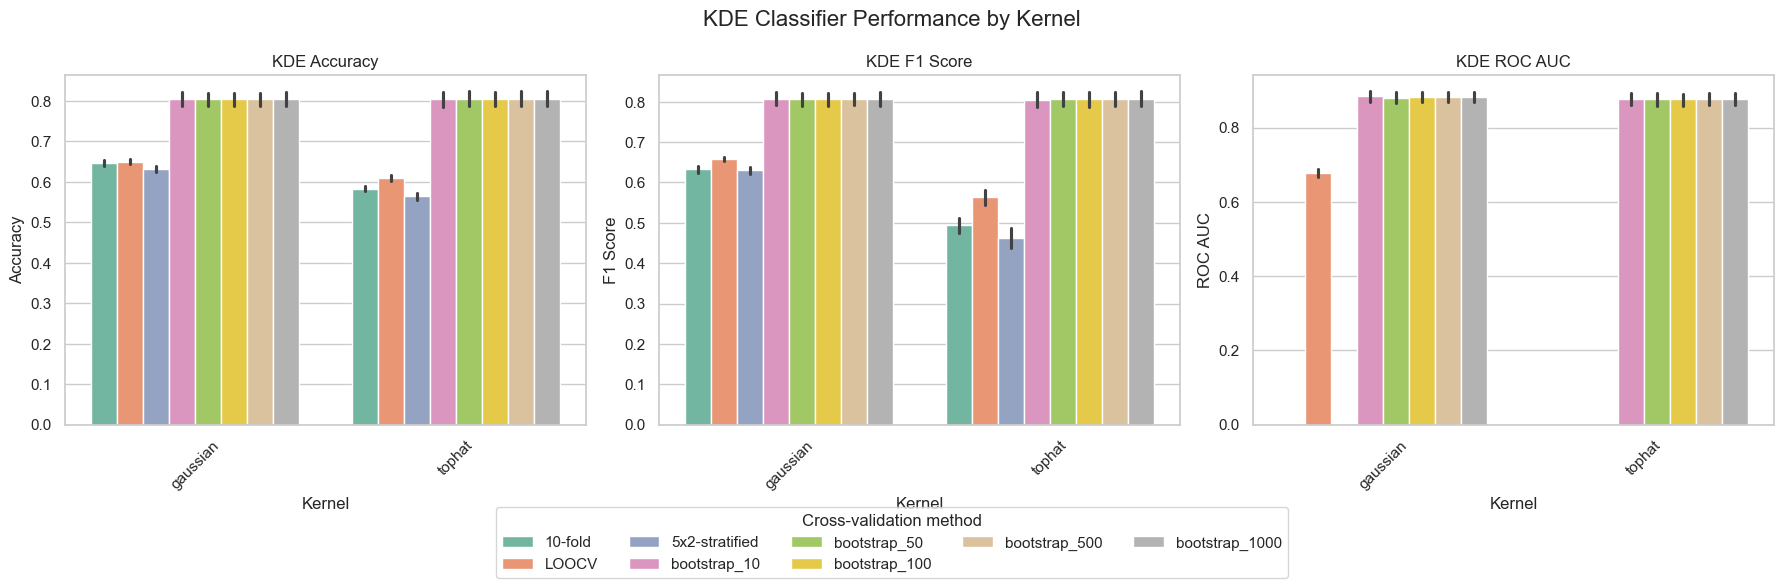

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Plot accuracy in the first subplot
sns.barplot(
    data=kde_df,
    x="kernel",
    y="accuracy",
    hue="cv",
    palette="Set2",
    ax=axes[0],
)
axes[0].set_xlabel("Kernel")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("KDE Accuracy")
axes[0].tick_params(axis="x", rotation=45)

# Plot F1 score in the second subplot
sns.barplot(
    data=kde_df,
    x="kernel",
    y="f1",
    hue="cv",
    palette="Set2",
    ax=axes[1],
)
axes[1].set_xlabel("Kernel")
axes[1].set_ylabel("F1 Score")
axes[1].set_title("KDE F1 Score")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend().set_visible(False)  # Hide redundant legend

# Plot ROC AUC in the third subplot
sns.barplot(
    data=kde_df,
    x="kernel",
    y="roc_auc",
    hue="cv",
    palette="Set2",
    ax=axes[2],
)
axes[2].set_xlabel("Kernel")
axes[2].set_ylabel("ROC AUC")
axes[2].set_title("KDE ROC AUC")
axes[2].tick_params(axis="x", rotation=45)
axes[2].legend().set_visible(False)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Cross-validation method",
    loc="upper center",
    bbox_to_anchor=(0.5, 0),
    ncol=5,
)
axes[0].get_legend().remove()  # Remove the individual legend from the first plot

fig.suptitle("KDE Classifier Performance by Kernel", fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15)

plt.show()

## Evaluación final de los modelos

Para la simplicidad de a la hora de realizar la evaluación final de los modelos, se ha decidido tomar la métrica Accuracy (las clases están balanceadas) como criterio principal a la hora de decidir cuál es el mejor conjunto de hiperparámetros. Con esto se procederá a entrenar el modelo con los mejores hiperparámetros y se procederá a realizar la evaluación final. Esto se hará para, por ejemplo, el método 10-Fold Cross Validation. Así se facilita la visualización, sin tener que realizar 15 gráficas (2 modelos x 5 métodos de muestreo)

### K-NN

In [80]:
# Hiperparámetros óptimos según Accuracy y 10-Fold Cross Validation
mask_10f = knn_df["cv"] == "10-fold"
knn_df_10f = knn_df[mask_10f]
n_neighbors_opt = int(
    knn_df_10f[knn_df_10f["accuracy"] == knn_df_10f["accuracy"].max()][
        "n_neighbors"
    ].mean()
)
print(f"Optimal number of neighbors for KNN (10-Fold CV): {n_neighbors_opt}")

Optimal number of neighbors for KNN (10-Fold CV): 3


In [ ]:
knn = KNeighborsClassifier(n_neighbors=n_neighbors_opt)
knn.fit(X_train, y_train)
y_pred_proba_knn = knn.predict_proba(X_test)
y_pred_knn = knn.predict(X_test)

In [54]:
classification_report_knn_dict = classification_report(
    y_test, y_pred_knn, output_dict=True
)
classification_report_knn_dict["AUC"] = roc_auc_score(
    y_test, y_pred_proba_knn[:, 1], labels=np.unique(y_test)
)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

  versicolor       0.63      0.80      0.71        15
   virginica       0.73      0.53      0.62        15

    accuracy                           0.67        30
   macro avg       0.68      0.67      0.66        30
weighted avg       0.68      0.67      0.66        30



### RDA

In [ ]:
# Hiperparámetros óptimos según Accuracy y 10-Fold Cross Validation
mask_10f = lda_df["cv"] == "10-fold"
lda_df_10f = lda_df[mask_10f]
shrinkage_opt = float(
    lda_df_10f[lda_df_10f["accuracy"] == lda_df_10f["accuracy"].max()][
        "shrinkage"
    ].mean()
)  # Get the mean value of shrinkage_opt
print(f"Optimal shrinkage for RDA (10-Fold CV): {shrinkage_opt}")

Optimal shrinkage for RDA (10-Fold CV): 0.055


In [ ]:
rda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage=shrinkage_opt)
rda.fit(X_train, y_train)
y_pred_proba_rda = rda.predict_proba(X_test)
y_pred_rda = rda.predict(X_test)

In [51]:
classification_report_rda_dict = classification_report(
    y_test, y_pred_rda, output_dict=True
)
classification_report_rda_dict["AUC"] = roc_auc_score(
    y_test, y_pred_proba_rda[:, 1], labels=np.unique(y_test)
)
print(classification_report(y_test, y_pred_rda))

              precision    recall  f1-score   support

  versicolor       0.65      0.87      0.74        15
   virginica       0.80      0.53      0.64        15

    accuracy                           0.70        30
   macro avg       0.73      0.70      0.69        30
weighted avg       0.72      0.70      0.69        30



### KDE

In [34]:
# Hiperparámetros óptimos según Accuracy y 10-Fold Cross Validation
mask_10f = kde_df["cv"] == "10-fold"
kde_df_10f = kde_df[mask_10f]
kernel_band_opt = kde_df_10f[kde_df_10f["accuracy"] == kde_df_10f["accuracy"].max()][
    ["kernel", "bandwidth"]
]
kernel = kernel_band_opt["kernel"].values[0]
print(f"Optimal kernel for KDE (10-Fold CV): {kernel}")
bandwidth = kernel_band_opt["bandwidth"].mean()
print(f"Optimal bandwidth for KDE (10-Fold CV): {bandwidth}")

Optimal kernel for KDE (10-Fold CV): gaussian
Optimal bandwidth for KDE (10-Fold CV): 0.8846153846153848


In [ ]:
kde = KDEClassifier(bandwidth=bandwidth, kernel=kernel)
kde.fit(X_train, y_train)
y_pred_proba_kde = kde.predict_proba(X_test)
y_pred_kde = kde.predict(X_test)

In [56]:
classification_report_kde_dict = classification_report(
    y_test, y_pred_kde, output_dict=True
)
classification_report_kde_dict["AUC"] = roc_auc_score(
    y_test, y_pred_proba_kde[:, 1], labels=np.unique(y_test)
)
print(classification_report(y_test, y_pred_kde))

              precision    recall  f1-score   support

  versicolor       0.65      0.87      0.74        15
   virginica       0.80      0.53      0.64        15

    accuracy                           0.70        30
   macro avg       0.73      0.70      0.69        30
weighted avg       0.72      0.70      0.69        30



### ROC AUC

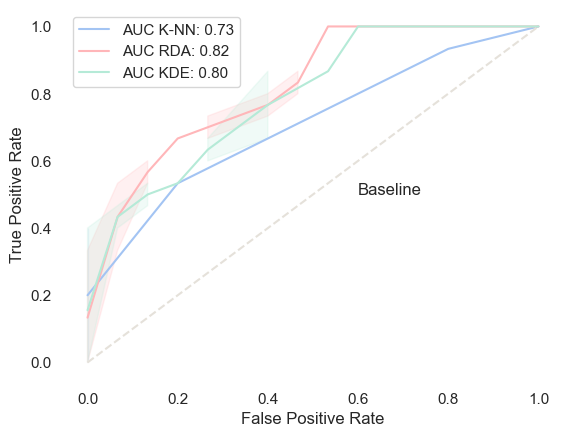

In [73]:
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn[:, 1], pos_label="virginica")
fpr_rda, tpr_rda, _ = roc_curve(y_test, y_pred_proba_rda[:, 1], pos_label="virginica")
fpr_kde, tpr_kde, _ = roc_curve(y_test, y_pred_proba_kde[:, 1], pos_label="virginica")

sns.set_style("white")

sns.lineplot(
    x=fpr_knn,
    y=tpr_knn,
    label=f"AUC K-NN: {classification_report_knn_dict["AUC"]:.2f}",
    color="#A3C4F3",
)
sns.lineplot(
    x=fpr_rda,
    y=tpr_rda,
    label=f"AUC RDA: {classification_report_rda_dict["AUC"]:.2f}",
    color="#FFB6B9",
)
sns.lineplot(
    x=fpr_kde,
    y=tpr_kde,
    label=f"AUC KDE: {classification_report_kde_dict["AUC"]:.2f}",
    color="#B5EAD7",
)

plt.plot([0, 1], [0, 1], color="#E5E1DA", linestyle="--")
# plt.fill_between(fpr, tpr, color='#FF8080', alpha=0.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0.6, 0.5, "Baseline")
plt.legend()
plt.gca().set_frame_on(False)
plt.show()
plt.close()

### Metrics Comparision

In [75]:
import plotly.graph_objects as go

# Métricas y valores
metrics = ["F1", "Accuracy", "Precision", "Recall", "AUC"]

# Valores de cada modelo
values_knn = [
    classification_report_knn_dict["macro avg"]["f1-score"],
    classification_report_knn_dict["accuracy"],
    classification_report_knn_dict["macro avg"]["precision"],
    classification_report_knn_dict["macro avg"]["recall"],
    classification_report_knn_dict["AUC"],
]
values_rda = [
    classification_report_rda_dict["macro avg"]["f1-score"],
    classification_report_rda_dict["accuracy"],
    classification_report_rda_dict["macro avg"]["precision"],
    classification_report_rda_dict["macro avg"]["recall"],
    classification_report_rda_dict["AUC"],
]
values_kde = [
    classification_report_kde_dict["macro avg"]["f1-score"],
    classification_report_kde_dict["accuracy"],
    classification_report_kde_dict["macro avg"]["precision"],
    classification_report_kde_dict["macro avg"]["recall"],
    classification_report_kde_dict["AUC"],
]

# Radar charts necesitan cerrar el círculo
metrics += [metrics[0]]
values_knn += [values_knn[0]]
values_rda += [values_rda[0]]
values_kde += [values_kde[0]]

# Crear la figura
fig = go.Figure()

fig.add_trace(
    go.Scatterpolar(r=values_knn, theta=metrics, fill="toself", name="Modelo K-NN")
)
fig.add_trace(
    go.Scatterpolar(r=values_rda, theta=metrics, fill="toself", name="Modelo RDA")
)
fig.add_trace(
    go.Scatterpolar(r=values_kde, theta=metrics, fill="toself", name="Modelo KDE")
)

# Layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1],  # Ajusta según tus métricas
        )
    ),
    showlegend=True,
    title="Comparativa de Modelos - Radar Chart",
)

fig.show()

## Informe Final

### Variación de los hiperparámetros óptimos según la técnica de remuestreo y Diferencias entre las métricas cálculadas por remuestreo como leave‑one‑out, K‑Fold, Dietterich y bootstrapping

A través de las gráficas comparativas obtenidas se pueden obtener las siguientes conclusiones:

El comportamiento de la variación del valor de las métricas AUC, Accuracy y F1 sigue una misma tendencia en los métodos de remuestro basados en CV. Por ejemplo, a medida que van aumentando los valores de k (n_neighbours) en el caso de K-NN, los valores de las métricas se comportan de manera similar para 10-Fold CV, LOOCV y 5x2 CV. Sin embargo, esta tendencia no coincide con los métodos de bootstrap; estos mismos muestran generalmente funciones monótonas decrecientes y separadas de los métodos de CV. También se observa en el método boostrap que, los valores de las métricas en función del valor del hiperparámetro evolucionan de manera muy similar para todos los tipos de replicaciones empleadas.

Es curioso ver que, a valores bajos de hiperparámetros, los valores de las métricas para método boostrap son más elevados que para métodos de CV, y a medida que incrementa el hiperparámetro, las curvas de ambos tipos de métodos tienden a acercarse. 

Esto puede deberse a que en bootstrap se está evaluando siempre sobre la misma muestra con reemplazo que es usada para entrenar, así que, por ejemplo, un KDE con bandwidth muy pequeño se ajusta casi “a medida” de esa réplica y da resultados artificialmente altos (sobreajuste total al train set). Conforme subes el bandwidth, empiezas a suavizar la densidad y ya no “encajas” tan perfectamente en esa réplica, por eso las métricas caen. 

En cambio, en los métodos CV (10-fold, 5×2, LOOCV) se está midiendo sobre datos que el modelo no ha visto. Ahí un bandwidth demasiado pequeño produce una densidad demasiado rugosa (sobreajuste al fold de train) y peor predicción sobre el fold de validación, de modo que los scores comienzan bajos y suben al aumentar el bandwidth (menor varianza, mejor generalización).

### Ventajas y limitaciones de optimizar con accuracy, AUC o F1

Optimizar con accuracy es sencillo e intuitivo (porcentaje de aciertos), pero puede resultar engañoso en casos de clases desbalanceadas y depende de un umbral fijo; AUC evalúa la capacidad de ranking del modelo integrando su rendimiento sobre todos los umbrales, es robusto a desequilibrios de clase y no requiere elegir un corte, pero no refleja directamente cómo funcionará el modelo en un umbral concreto. En cuanto a F1-score, esta métrica equilibra precisión y recall, siendo muy útil cuando interesa mitigar falsos positivos y falsos negativos en casos de datos con clases desbalanceadas, aunque sigue dependiendo de un umbral.